## Capstone- Cancer Histopathology: Image Data Generator

Dataset:
- A. Borkowski, "Lung and Colon Cancer Histopathological Images", Kaggle.com, 2020. [Online]. Available: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images. [Accessed: 30- Jul- 2022].

Sources:
- Borkowski AA, Bui MM, Thomas LB, Wilson CP, DeLand LA, Mastorides SM. Lung and Colon Cancer Histopathological Image Dataset (LC25000). arXiv:1912.12142v1 [eess.IV], 2019

Image Labels:
- Lung benign tissue: 3
- Lung adenocarcinoma: 2
- Lung squamous cell carcinoma: 4
- Colon adenocarcinoma: 0
- Colon benign tissue: 1

### Import Libraries

In [1]:
## Import Libraries
import numpy as np
import pandas as pd
from pathlib import Path
import time
import math

# import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.utils import to_categorical
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Load Data

In [2]:
import PIL
from PIL import Image
import glob
import cv2
import os, os.path
from numpy import asarray

import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from IPython.display import display, HTML
import pymongo
from pymongo import MongoClient
import io
from bson.binary import Binary

### Data Preprocessing

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
data_dir = "./lung_colon_image_set/lung_image_sets"

# 80-20 Split
data = ImageDataGenerator(validation_split = 0.3)

BATCH_SIZE = 128

# 224 x 224 -- The minimum for EfficientNetB7, you can go as high as 600 x 600
X = Y = 96

train_ds = data.flow_from_directory(data_dir,
                                    class_mode = "categorical",
                                    target_size = (X, Y),
                                    color_mode="rgb",
                                    batch_size = BATCH_SIZE, 
                                    shuffle = False,
                                    subset='training',
                                    seed = 42)

validation = data.flow_from_directory(data_dir,
                                      class_mode = "categorical",
                                      target_size = (X, Y),
                                      color_mode="rgb",
                                      batch_size = BATCH_SIZE, 
                                      shuffle = False,
                                      subset='validation',
                                      seed = 42)

Found 17500 images belonging to 5 classes.
Found 7500 images belonging to 5 classes.


In [5]:
train_ds[0][0][0].shape

(128, 128, 3)

In [6]:
train_ds.labels[1]

0

In [7]:
dataPath= "./lung_colon_image_set/lung_image_sets"
categories= os.listdir(dataPath)
labels= [i for i in range(len(categories))]
# empty dictionary
labelDict= dict(zip(categories, labels))

print(labelDict)
print(categories)
print(labels)

{'colon_aca': 0, 'colon_n': 1, 'lung_aca': 2, 'lung_n': 3, 'lung_scc': 4}
['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']
[0, 1, 2, 3, 4]


In [8]:
# %%time
# imgSize= 96
# data= []
# target= []
# tupleArr= []
# for category in categories:
#     folderPath= os.path.join(dataPath, category)
#     imgNames= os.listdir(folderPath)
    
#     for imgName in imgNames:
#         imgPath= os.path.join(folderPath, imgName)
#         img= Image.open(imgPath)
    
#         try:
#             resized= np.array(img.resize((imgSize, imgSize)))
#             data.append(resized)
#             target.append(labelDict[category])
#             tupleGrp= (resized, labelDict[category])
#             tupleArr.append(tupleGrp)
#         except Exception as e:
#             print('Exception:', e)

In [9]:
# np.save('data96.npy', data)
# np.save('target96.npy', target)
# np.save('tupleData96.npy', tupleArr)

In [10]:
imageArr= np.load('data96.npy', allow_pickle= True)
targetArr= np.load('target96.npy', allow_pickle= True)
tupleData= np.load('tupleData96.npy', allow_pickle= True)

In [11]:
# check Pillow version number
print('Pillow Version:', PIL.__version__)

Pillow Version: 9.1.0


In [12]:
dfMergeData= pd.DataFrame(np.load('tupleData96.npy', allow_pickle= True), columns=['imageVector', 'label'])
dfMergeData.head()

,imageVector,label
0,"[[[249, 205, 236], [238, 197, 233], [244, 233,...",0
1,"[[[221, 185, 239], [219, 185, 230], [229, 199,...",0
2,"[[[253, 254, 249], [254, 255, 250], [254, 255,...",0
3,"[[[237, 220, 231], [238, 223, 232], [211, 200,...",0
4,"[[[249, 137, 196], [251, 165, 218], [248, 180,...",0


In [13]:
# def imageFromArray(imgFile):
#     data= array_to_img(imgFile)
#     return data

In [14]:
# dfMergeData['backToImage']= dfMergeData['imageVector'].apply(lambda x: imageFromArray(x))

In [15]:
# dfMergeData.head()

In [16]:
# dfMergeData['label'][5000]

In [17]:
# dfMergeData['backToImage'][5000]

In [18]:
dfData= dfMergeData.sample(frac=1).reset_index(drop= True)
dfData.sample(10)

,imageVector,label
24056,"[[[201, 203, 202], [202, 204, 203], [202, 204,...",3
16107,"[[[194, 170, 223], [175, 157, 219], [184, 167,...",0
19627,"[[[174, 165, 233], [129, 115, 215], [84, 62, 2...",2
2869,"[[[147, 130, 249], [149, 135, 252], [131, 104,...",4
17939,"[[[148, 125, 204], [156, 115, 210], [176, 142,...",1
16071,"[[[211, 205, 207], [211, 205, 211], [212, 206,...",3
8826,"[[[162, 122, 234], [157, 115, 235], [155, 109,...",4
6936,"[[[219, 199, 184], [214, 188, 183], [203, 164,...",3
19657,"[[[196, 60, 173], [193, 56, 171], [198, 109, 2...",4
12622,"[[[252, 241, 248], [243, 222, 245], [225, 188,...",1


In [19]:
dfArr= []
for i in dfData.values:
    dfArr.append(i)

In [20]:
np.save('shuffledData96.npy', dfArr)

In [22]:
dfShuffledData= pd.DataFrame(np.load('shuffledData96.npy', allow_pickle= True),
                             columns=['imageVector', 'label'])
dfShuffledData.head()

,imageVector,label
0,"[[[201, 205, 208], [201, 205, 208], [203, 204,...",3
1,"[[[234, 210, 228], [237, 217, 234], [232, 214,...",1
2,"[[[173, 133, 238], [160, 119, 233], [150, 110,...",2
3,"[[[143, 79, 199], [127, 70, 194], [126, 61, 19...",1
4,"[[[220, 169, 231], [248, 232, 245], [255, 255,...",1


In [23]:
dfShuffledData['label'].value_counts()

3    5000
1    5000
2    5000
4    5000
0    5000
Name: label, dtype: int64

In [24]:
def normalizeImage(image):
    imgVect= image/ 255.0
    return imgVect

In [25]:
def imageFromArray(imgFile):
    data= array_to_img(imgFile)
    return data

In [26]:
dfShuffledData['scaledImage']= dfShuffledData['imageVector'].apply(normalizeImage)
dfShuffledData['backToImage']= dfShuffledData['scaledImage'].apply(lambda x: imageFromArray(x))

In [27]:
dfShuffledData.head()

,imageVector,label,scaledImage,backToImage
0,"[[[201, 205, 208], [201, 205, 208], [203, 204,...",3,"[[[0.788235294117647, 0.803921568627451, 0.815...",<PIL.Image.Image image mode=RGB size=96x96 at ...
1,"[[[234, 210, 228], [237, 217, 234], [232, 214,...",1,"[[[0.9176470588235294, 0.8235294117647058, 0.8...",<PIL.Image.Image image mode=RGB size=96x96 at ...
2,"[[[173, 133, 238], [160, 119, 233], [150, 110,...",2,"[[[0.6784313725490196, 0.5215686274509804, 0.9...",<PIL.Image.Image image mode=RGB size=96x96 at ...
3,"[[[143, 79, 199], [127, 70, 194], [126, 61, 19...",1,"[[[0.5607843137254902, 0.30980392156862746, 0....",<PIL.Image.Image image mode=RGB size=96x96 at ...
4,"[[[220, 169, 231], [248, 232, 245], [255, 255,...",1,"[[[0.8627450980392157, 0.6627450980392157, 0.9...",<PIL.Image.Image image mode=RGB size=96x96 at ...


In [30]:
%%time
imgVectData= np.array(dfShuffledData['scaledImage'].tolist())
imgVectData.shape

CPU times: total: 28.1 s
Wall time: 28.2 s


(25000, 96, 96, 3)

In [31]:
labelData= to_categorical(dfShuffledData['label'].values.reshape(25000, 1))
labelData.shape

(25000, 5)

In [32]:
from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasRegressor
from keras.layers import BatchNormalization

In [33]:
from sklearn.base import BaseEstimator, TransformerMixin

In [34]:
def baseline_model02():
    # create model
    model= Sequential()
    model.add(layers.Conv2D(16, (3, 3), activation= 'relu', data_format= 'channels_last',
                            padding= 'valid' ,input_shape= (96, 96, 3)))
    model.add(BatchNormalization(momentum= 0.01))
    model.add(layers.MaxPooling2D((3, 3)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, (3, 3), activation= 'relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(5, activation='softmax'))
    # Compile model
    model.compile(
        optimizer= 'adam',
        loss= 'categorical_crossentropy',
        metrics= ['accuracy'])
    return model

# evaluate model
clf= KerasClassifier(baseline_model02, validation_split= 0.3, epochs= 5, batch_size= 20, verbose= 1)

In [35]:
def baseline_model03():
    # create model
    model= Sequential()
#     model.add(layers.Conv2D(32, (1, 1), activation= 'relu', data_format= 'channels_last',
#                         padding= 'valid' ,input_shape= rzImageArr.shape[1:]))
    model.add(layers.Conv2D(32, (1, 1), activation= 'relu',input_shape= ImageArr.shape[1:]))
    model.add(layers.Conv2D(32, (1, 1), activation= 'relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation= 'relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(16, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
#     model.add(layers.Dropout(0.2))
    # model.add(layers.Dense(64, activation='relu'))
    # model.add(layers.Dropout(0.2))
#     model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(5, activation='softmax'))
    # Compile model
    model.compile(
        optimizer= 'adam',
        loss= 'categorical_crossentropy',
        metrics= ['accuracy'])
    return model

# evaluate model
clf01= KerasClassifier(baseline_model03, validation_split= 0.3, epochs= 20, batch_size= 10, verbose= 1)

In [36]:
class preprocessor(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y= None):
        return self

    def transform(self, X):
        return [X/ 255.0]

In [37]:
from sklearn.pipeline import make_pipeline

In [38]:
%%time
pipe= make_pipeline(preprocessor(), clf)
pipe.fit(imgVectData, labelData)

Epoch 1/5
875/875 [==============================] - 125s 139ms/step - loss: 0.5173 - accuracy: 0.7723 - val_loss: 0.6008 - val_accuracy: 0.7652
Epoch 2/5
875/875 [==============================] - 127s 145ms/step - loss: 0.3268 - accuracy: 0.8706 - val_loss: 0.3727 - val_accuracy: 0.8520
Epoch 3/5
875/875 [==============================] - 129s 148ms/step - loss: 0.2394 - accuracy: 0.9064 - val_loss: 0.1890 - val_accuracy: 0.9191
Epoch 4/5
875/875 [==============================] - 127s 145ms/step - loss: 0.1991 - accuracy: 0.9226 - val_loss: 0.2962 - val_accuracy: 0.8891
Epoch 5/5
875/875 [==============================] - 131s 150ms/step - loss: 0.1676 - accuracy: 0.9346 - val_loss: 0.2127 - val_accuracy: 0.9232
CPU times: total: 43min 36s
Wall time: 10min 59s


Pipeline(steps=[('preprocessor', preprocessor()),
                ('kerasclassifier',
                 <keras.wrappers.scikit_learn.KerasClassifier object at 0x0000017F0BE15CF0>)])

In [39]:
rzImageArr= []
for filename in glob.glob('./lung_colon_image_set/testImageSet/*.jpeg'): #assuming jpeg
    im= Image.open(filename)
    rzImage= np.array(im.resize((96, 96)))
    rzImageArr.append(rzImage)

In [40]:
%%time
imageList= []
for i in rzImageArr:
    image= Image.fromarray(i)
    imageList.append(image)
imageList

CPU times: total: 15.6 ms
Wall time: 52.3 ms


[<PIL.Image.Image image mode=RGB size=96x96>,
 <PIL.Image.Image image mode=RGB size=96x96>,
 <PIL.Image.Image image mode=RGB size=96x96>,
 <PIL.Image.Image image mode=RGB size=96x96>,
 <PIL.Image.Image image mode=RGB size=96x96>,
 <PIL.Image.Image image mode=RGB size=96x96>,
 <PIL.Image.Image image mode=RGB size=96x96>,
 <PIL.Image.Image image mode=RGB size=96x96>,
 <PIL.Image.Image image mode=RGB size=96x96>,
 <PIL.Image.Image image mode=RGB size=96x96>]

In [41]:
dfTest= pd.DataFrame(imageList, columns=['image'])
dfTest

,image
0,<PIL.Image.Image image mode=RGB size=96x96 at ...
1,<PIL.Image.Image image mode=RGB size=96x96 at ...
2,<PIL.Image.Image image mode=RGB size=96x96 at ...
3,<PIL.Image.Image image mode=RGB size=96x96 at ...
4,<PIL.Image.Image image mode=RGB size=96x96 at ...
5,<PIL.Image.Image image mode=RGB size=96x96 at ...
6,<PIL.Image.Image image mode=RGB size=96x96 at ...
7,<PIL.Image.Image image mode=RGB size=96x96 at ...
8,<PIL.Image.Image image mode=RGB size=96x96 at ...
9,<PIL.Image.Image image mode=RGB size=96x96 at ...


In [42]:
def imageToArray(imgFile):
    data= img_to_array(imgFile)
    return data

In [43]:
%%time
dfTest['imageVector']= dfTest['image'].apply(lambda x: imageToArray(x))
dfTest['scaledImage']= dfTest['imageVector'].apply(lambda x: normalizeImage(x))

CPU times: total: 15.6 ms
Wall time: 100 ms


In [44]:
dfTest

,image,imageVector,scaledImage
0,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[249.0, 205.0, 236.0], [238.0, 197.0, 233.0]...","[[[0.9764706, 0.8039216, 0.9254902], [0.933333..."
1,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[250.0, 240.0, 247.0], [228.0, 186.0, 238.0]...","[[[0.98039216, 0.9411765, 0.96862745], [0.8941..."
2,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[242.0, 224.0, 236.0], [225.0, 195.0, 233.0]...","[[[0.9490196, 0.8784314, 0.9254902], [0.882352..."
3,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[251.0, 249.0, 229.0], [245.0, 228.0, 224.0]...","[[[0.9843137, 0.9764706, 0.8980392], [0.960784..."
4,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[212.0, 198.0, 242.0], [210.0, 202.0, 245.0]...","[[[0.83137256, 0.7764706, 0.9490196], [0.82352..."
5,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[143.0, 79.0, 210.0], [137.0, 79.0, 215.0], ...","[[[0.56078434, 0.30980393, 0.8235294], [0.5372..."
6,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[74.0, 35.0, 146.0], [124.0, 55.0, 154.0], [...","[[[0.2901961, 0.13725491, 0.57254905], [0.4862..."
7,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[203.0, 156.0, 202.0], [200.0, 156.0, 196.0]...","[[[0.79607844, 0.6117647, 0.7921569], [0.78431..."
8,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[144.0, 93.0, 213.0], [141.0, 94.0, 213.0], ...","[[[0.5647059, 0.3647059, 0.8352941], [0.552941..."
9,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[94.0, 71.0, 199.0], [104.0, 72.0, 201.0], [...","[[[0.36862746, 0.2784314, 0.78039217], [0.4078..."


In [45]:
def imageFromArray(imgFile):
    data= array_to_img(imgFile)
    return data

In [46]:
%%time
dfTest['backToImage']= dfTest['scaledImage'].apply(lambda x: imageFromArray(x))

CPU times: total: 15.6 ms
Wall time: 48.1 ms


In [47]:
dfTest

,image,imageVector,scaledImage,backToImage
0,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[249.0, 205.0, 236.0], [238.0, 197.0, 233.0]...","[[[0.9764706, 0.8039216, 0.9254902], [0.933333...",<PIL.Image.Image image mode=RGB size=96x96 at ...
1,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[250.0, 240.0, 247.0], [228.0, 186.0, 238.0]...","[[[0.98039216, 0.9411765, 0.96862745], [0.8941...",<PIL.Image.Image image mode=RGB size=96x96 at ...
2,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[242.0, 224.0, 236.0], [225.0, 195.0, 233.0]...","[[[0.9490196, 0.8784314, 0.9254902], [0.882352...",<PIL.Image.Image image mode=RGB size=96x96 at ...
3,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[251.0, 249.0, 229.0], [245.0, 228.0, 224.0]...","[[[0.9843137, 0.9764706, 0.8980392], [0.960784...",<PIL.Image.Image image mode=RGB size=96x96 at ...
4,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[212.0, 198.0, 242.0], [210.0, 202.0, 245.0]...","[[[0.83137256, 0.7764706, 0.9490196], [0.82352...",<PIL.Image.Image image mode=RGB size=96x96 at ...
5,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[143.0, 79.0, 210.0], [137.0, 79.0, 215.0], ...","[[[0.56078434, 0.30980393, 0.8235294], [0.5372...",<PIL.Image.Image image mode=RGB size=96x96 at ...
6,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[74.0, 35.0, 146.0], [124.0, 55.0, 154.0], [...","[[[0.2901961, 0.13725491, 0.57254905], [0.4862...",<PIL.Image.Image image mode=RGB size=96x96 at ...
7,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[203.0, 156.0, 202.0], [200.0, 156.0, 196.0]...","[[[0.79607844, 0.6117647, 0.7921569], [0.78431...",<PIL.Image.Image image mode=RGB size=96x96 at ...
8,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[144.0, 93.0, 213.0], [141.0, 94.0, 213.0], ...","[[[0.5647059, 0.3647059, 0.8352941], [0.552941...",<PIL.Image.Image image mode=RGB size=96x96 at ...
9,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[94.0, 71.0, 199.0], [104.0, 72.0, 201.0], [...","[[[0.36862746, 0.2784314, 0.78039217], [0.4078...",<PIL.Image.Image image mode=RGB size=96x96 at ...


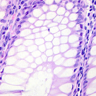

In [48]:
dfTest['backToImage'][2]

In [49]:
imgTestData= np.asarray(dfTest['scaledImage'].tolist())
# imgTestData= np.expand_dims(imgTestData)
imgTestData.shape

(10, 96, 96, 3)

In [50]:
predict_x= pipe.predict(imgTestData)
# classes_x= np.argmax(predict_x, axis=1)
# classes_x= predict_x.argmax(axis= 1)
predict_x

1/1 [==============================] - 0s 218ms/step


array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4])

### Normalize and assign categorical labels

In [51]:
rzImageArr= imageArr/ 255.0

In [52]:
rzImageArr.shape

(25000, 96, 96, 3)

In [53]:
newTarget= to_categorical(targetArr)

In [54]:
newTarget.shape

(25000, 5)

### CNN Model

In [55]:
rzImageArr.shape

(25000, 96, 96, 3)

In [56]:
newTarget.shape

(25000, 5)

In [57]:
rzImageArr.shape[1:]

(96, 96, 3)

In [58]:
%%time
X_train, X_test, y_train, y_test = train_test_split(rzImageArr, newTarget, test_size = 0.3,
                                                    random_state = 65)

CPU times: total: 11.3 s
Wall time: 14.8 s


### Create the model's architecture
- **NOTE ALERT**: Take into account the volume of data and parameters. Time and processing escalate quite fast.
- **NOTE ALERT**: It is likely this data will require more complex models.

In [59]:
# Set up the model architecture
model= Sequential()
model.add(layers.Conv2D(32, (1, 1), activation= 'relu', data_format= 'channels_last',
                        padding= 'valid' ,input_shape= rzImageArr.shape[1:]))
model.add(layers.Conv2D(64, (1, 1), activation= 'relu'))
model.add(BatchNormalization(momentum= 0.01))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation= 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))

In [60]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 96, 96, 32)        128       
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 64)        2112      
                                                                 
 batch_normalization_1 (Batc  (None, 96, 96, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 64)      

In [61]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
# model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
# model.add(layers.Dropout(0.2))
model.add(layers.Dense(5, activation='softmax'))

In [62]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 96, 96, 32)        128       
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 64)        2112      
                                                                 
 batch_normalization_1 (Batc  (None, 96, 96, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 64)      

### Complie the model

In [63]:
model.compile(
    optimizer= 'adam',
    loss = 'categorical_crossentropy',
#     loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True),
    metrics= ['accuracy'])

### Fit the training data

In [64]:
X_train.shape

(17500, 96, 96, 3)

In [65]:
y_train.shape

(17500, 5)

In [66]:
%%time
# Fit the model on a training set
history= model.fit(
    X_train,
    y_train,
    validation_split= 0.3,
#     validation_data=(X2_test, y2_test),
    epochs= 5,
    batch_size= 20,
    verbose= 1)

Epoch 1/5
613/613 [==============================] - 264s 428ms/step - loss: 0.6621 - accuracy: 0.6384 - val_loss: 0.5910 - val_accuracy: 0.7537
Epoch 2/5
613/613 [==============================] - 289s 472ms/step - loss: 0.3866 - accuracy: 0.8380 - val_loss: 0.2194 - val_accuracy: 0.9141
Epoch 3/5
613/613 [==============================] - 282s 460ms/step - loss: 0.2271 - accuracy: 0.9133 - val_loss: 0.2361 - val_accuracy: 0.9076
Epoch 4/5
613/613 [==============================] - 283s 461ms/step - loss: 0.1685 - accuracy: 0.9385 - val_loss: 0.1742 - val_accuracy: 0.9310
Epoch 5/5
613/613 [==============================] - 284s 464ms/step - loss: 0.1497 - accuracy: 0.9456 - val_loss: 0.1184 - val_accuracy: 0.9577
CPU times: total: 1h 47min 13s
Wall time: 23min 24s


In [67]:
model.save('model.h5')

### Create Predictions

In [68]:
X_test.shape

(7500, 96, 96, 3)

In [69]:
%%time
# predictions = model.predict_classes(X_test)
predict_x= model.predict(X_test)
# classes_x= np.argmax(predict_x, axis=1)
classes_x= predict_x.argmax(axis= 1)

235/235 [==============================] - 30s 129ms/step
CPU times: total: 2min 28s
Wall time: 31.4 s


In [70]:
predArr= model.predict(imgTestData).argmax(axis= 1)

1/1 [==============================] - 0s 63ms/step


In [71]:
classes_x

array([2, 3, 1, ..., 2, 3, 3], dtype=int64)

In [73]:
predArr

array([0, 0, 1, 0, 2, 2, 3, 3, 4, 4], dtype=int64)

In [74]:
X_test.shape

(7500, 96, 96, 3)

In [75]:
y_test.shape

(7500, 5)

### Evaluate the model

In [76]:
%%time
score = model.evaluate(X_test, y_test, batch_size = 10)
print('\nTest loss: %.6f, Test accuracy: %.6f' % tuple(score))

750/750 [==============================] - 34s 46ms/step - loss: 0.1106 - accuracy: 0.9600

Test loss: 0.110593, Test accuracy: 0.960000
CPU times: total: 2min 21s
Wall time: 34.7 s


In [77]:
predArr.shape

(10,)

In [78]:
classes_x.shape

(7500,)

In [79]:
y_test.shape

(7500, 5)

In [80]:
y_test.shape

(7500, 5)

In [81]:
def print_cm(cm):
    d_size = max(len('%d' % cm.max()), len('%d' % cm.shape[1]))
    if min(cm.shape) > 10: # make sparse
        print('Sparse Matrix (*=diagonal)')
        fmt_r = 'r%%0%dd' % d_size
        fmt_c = ', c%%0%dd%%s= %%%dd' % (d_size, d_size)
        for i in range(cm.shape[0]):
            s = fmt_r % i
            for j in range(cm.shape[1]):
                if cm[i, j] > 0:
                    s += fmt_c % (j, '*' if i == j else ' ', cm[i, j])
            print(s)
    else: # make dense
        c = '%%%dd ' % d_size
        s = '%s| ' % (' ' * d_size)
        s += ''.join([c % i for i in range(len(cm[0]))])
        print(s)
        print('-' * len(s))
        for i, r in enumerate(cm):
            s = '%2d| ' % i
            s += c * len(r)
            print(s % tuple(r))

Image Labels:
- Lung benign tissue: 3
- Lung adenocarcinoma: 2
- Lung squamous cell carcinoma: 4
- Colon adenocarcinoma: 0
- Colon benign tissue: 1

In [82]:
y_test_target = np.array([x.argmax() for x in y_test])
cm = confusion_matrix(y_test_target, classes_x)
print_cm(cm)

    |    0    1    2    3    4 
-------------------------------
 0| 1455   36    2    0    5 
 1|   67 1458    0    0    0 
 2|    1    0 1412   10   44 
 3|    0    0    1 1483    0 
 4|    0    0  134    0 1392 


### Visualisation of cost

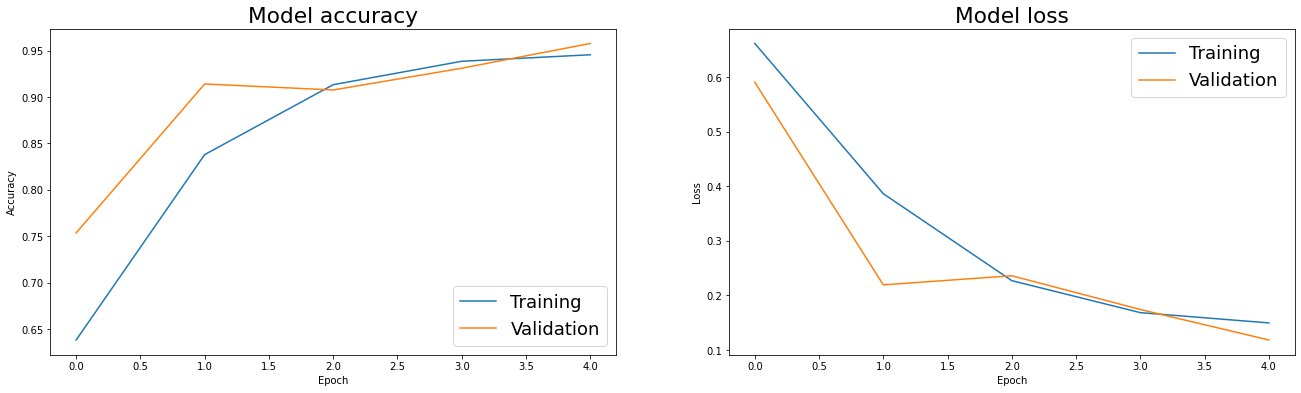

In [83]:
fig, ax = plt.subplots(1, 2, figsize = (18, 6))
fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

plt.rcParams.update({'font.size': 18})

# Plot training & validation accuracy values
ax[0].plot(history.history['accuracy'], label = 'Training')
ax[0].plot(history.history['val_accuracy'], label = 'Validation')
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend()

# Plot training & validation loss values
ax[1].plot(history.history['loss'], label = 'Training')
ax[1].plot(history.history['val_loss'], label = 'Validation')
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend()

plt.show()